In [325]:
! pip install imodels -q

In [326]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import pandas as pd
from sklearn.model_selection import train_test_split
from imodels import HSTreeClassifierCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

In [327]:
url = 'https://raw.githubusercontent.com/gwardasz/xai/refs/heads/main/recidivism.csv'
df = pd.read_csv(url)
employment_mapping = {'unemployed': 0, 'employed': 1}
df['employment'] = df['employment'].map(employment_mapping)

feature_cols = df.columns.values.tolist()[:-1]

X = df[feature_cols]
y = df.recid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
X_train, X_test, y_train, y_test = (x.to_numpy() for x in (X_train, X_test, y_train, y_test))


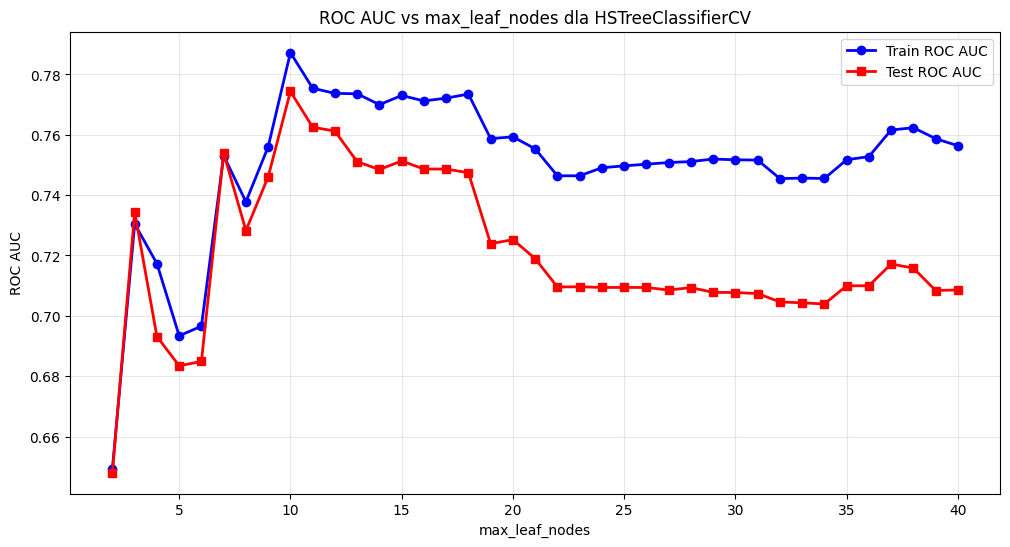

In [328]:
# Plot for different max_leaf_nodes values
max_leaf_nodes_values = range(2, 41)  # od 2 do 20
auc_scores_test = []
auc_scores_train = []

for max_leaf_nodes in max_leaf_nodes_values:
    model = HSTreeClassifierCV(max_leaf_nodes=max_leaf_nodes, random_state=42)
    model.fit(X_train, y_train, feature_names=feature_cols)
    preds_proba = model.predict_proba(X_test)

    # ROC AUC for test data
    preds_proba_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, preds_proba_test[:, 1])
    auc_scores_test.append(auc_test)

    # ROC AUC for train data
    preds_proba_train = model.predict_proba(X_train)
    auc_train = roc_auc_score(y_train, preds_proba_train[:, 1])
    auc_scores_train.append(auc_train)

    # print(f'max_leaf_nodes={max_leaf_nodes}, Train AUC={auc_train:.4f}, Test AUC={auc_test:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(max_leaf_nodes_values, auc_scores_train, marker='o', linewidth=2, markersize=6, label='Train ROC AUC', color='blue')
plt.plot(max_leaf_nodes_values, auc_scores_test, marker='s', linewidth=2, markersize=6, label='Test ROC AUC', color='red')
plt.xlabel('max_leaf_nodes')
plt.ylabel('ROC AUC')
plt.title('ROC AUC vs max_leaf_nodes dla HSTreeClassifierCV')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [329]:
model = HSTreeClassifierCV(max_leaf_nodes=5)
model.fit(X_train, y_train, feature_names=feature_cols)
preds = model.predict(X_test)
preds_proba = model.predict_proba(X_test)
print(f'test mse: {np.mean(np.square(preds-y_test)):0.2f}')
print(f'AUC={auc:.4f}')
#print(model)

print(model.get_params())

test mse: 0.31
AUC=0.7247
{'reg_param': np.float64(0.0), 'estimator_': DecisionTreeClassifier(max_leaf_nodes=5), 'shrinkage_scheme_': 'node_based', 'max_leaf_nodes': 5}


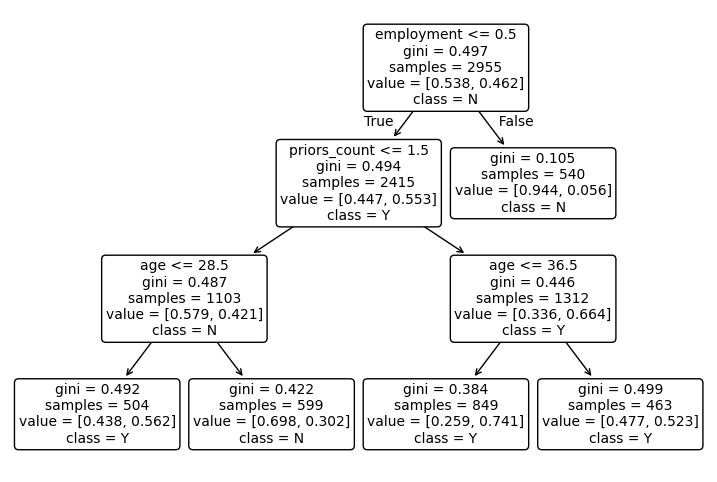

In [330]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,6))
_ = plot_tree(model.estimator_, feature_names=feature_cols, rounded=True, class_names=['N', 'Y'], fontsize=10, filled=True,)
plt.show()

To see the colours, we need to build a DecisionTreeClassifier without HS, as HS normalises the number of samples to a percentage probability.

In [331]:
from sklearn.tree import DecisionTreeClassifier

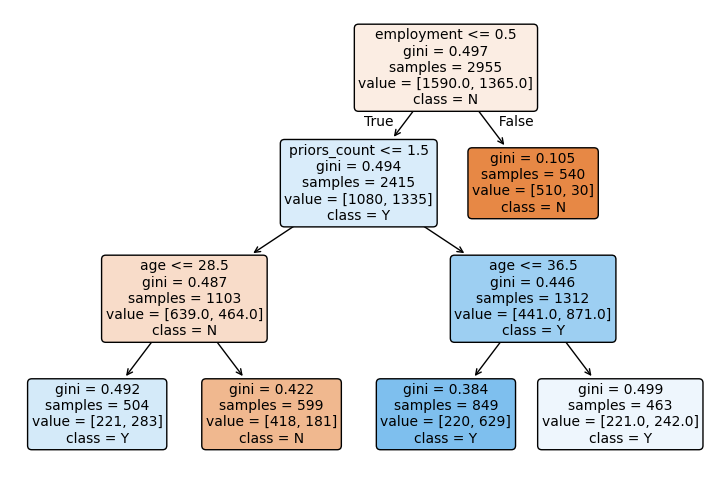

In [332]:
base_dt = DecisionTreeClassifier(max_leaf_nodes=5, random_state=411)
base_dt.fit(X_train, y_train)
plt.figure(figsize=(9,6))
plot_tree(base_dt,
          feature_names=feature_cols,
          class_names=['N','Y'],
          rounded=True,
          filled=True,
          fontsize=10)
plt.show()

Reg_param for max_leaf_nodes_value = 2: 0.0
Reg_param for max_leaf_nodes_value = 3: 0.0
Reg_param for max_leaf_nodes_value = 4: 0.0
Reg_param for max_leaf_nodes_value = 5: 0.0
Reg_param for max_leaf_nodes_value = 6: 0.0
Reg_param for max_leaf_nodes_value = 7: 0.0
Reg_param for max_leaf_nodes_value = 8: 0.0
Reg_param for max_leaf_nodes_value = 9: 0.0
Reg_param for max_leaf_nodes_value = 10: 0.0
Reg_param for max_leaf_nodes_value = 11: 0.0
Reg_param for max_leaf_nodes_value = 12: 0.0
Reg_param for max_leaf_nodes_value = 13: 0.0
Reg_param for max_leaf_nodes_value = 14: 0.0
Reg_param for max_leaf_nodes_value = 15: 0.0
Reg_param for max_leaf_nodes_value = 16: 0.0
Reg_param for max_leaf_nodes_value = 17: 0.0
Reg_param for max_leaf_nodes_value = 18: 0.0
Reg_param for max_leaf_nodes_value = 19: 1.0
Reg_param for max_leaf_nodes_value = 20: 1.0
Reg_param for max_leaf_nodes_value = 21: 1.0
Reg_param for max_leaf_nodes_value = 22: 1.0
Reg_param for max_leaf_nodes_value = 23: 1.0
Reg_param for max_

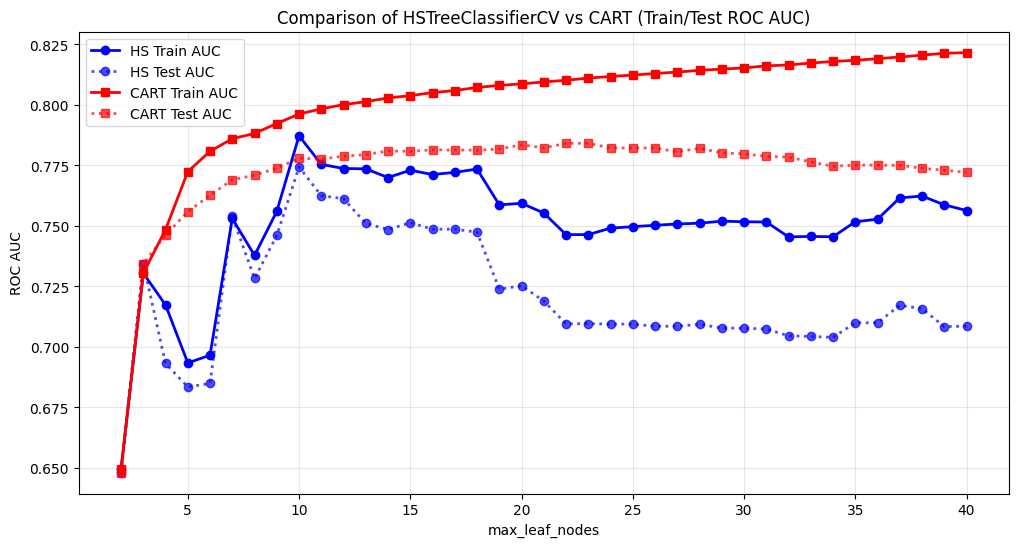

In [333]:
# Range of max_leaf_nodes values
max_leaf_nodes_values = range(2, 41)

# Initialize lists for AUC scores
auc_hs_train = []
auc_hs_test  = []
auc_dt_train = []
auc_dt_test  = []

# Iterate over different max_leaf_nodes
for ml in max_leaf_nodes_values:
    # Hierarchical Shrinkage Tree
    hs = HSTreeClassifierCV(max_leaf_nodes=ml, random_state=4)
    hs.fit(X_train, y_train, feature_names=feature_cols)
    proba_train = hs.predict_proba(X_train)[:, 1]
    proba_test  = hs.predict_proba(X_test)[:, 1]
    auc_hs_train.append(roc_auc_score(y_train, proba_train))
    auc_hs_test.append( roc_auc_score(y_test,  proba_test))
    print(f'Reg_param for max_leaf_nodes_value = {ml}: {hs.get_params()['reg_param']}')

    # Standard CART
    dt = DecisionTreeClassifier(max_leaf_nodes=ml, random_state=4)
    dt.fit(X_train, y_train)
    proba_train_dt = dt.predict_proba(X_train)[:, 1]
    proba_test_dt  = dt.predict_proba(X_test)[:, 1]
    auc_dt_train.append(roc_auc_score(y_train, proba_train_dt))
    auc_dt_test.append( roc_auc_score(y_test,  proba_test_dt))

# Plot the results
plt.figure(figsize=(12, 6))

plt.plot(max_leaf_nodes_values, auc_hs_train, marker='o', linestyle='-', linewidth=2, label='HS Train AUC', color='blue')
plt.plot(max_leaf_nodes_values, auc_hs_test,  marker='o', linestyle=':', linewidth=2, label='HS Test AUC',  color='blue', alpha=0.7)

plt.plot(max_leaf_nodes_values, auc_dt_train, marker='s', linestyle='-', linewidth=2, label='CART Train AUC', color='red')
plt.plot(max_leaf_nodes_values, auc_dt_test,  marker='s', linestyle=':', linewidth=2, label='CART Test AUC',  color='red', alpha=0.7)

plt.xlabel('max_leaf_nodes')
plt.ylabel('ROC AUC')
plt.title('Comparison of HSTreeClassifierCV vs CART (Train/Test ROC AUC)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()